In [63]:
import pandas as pd 
import numpy as np
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
import pandas_datareader as pdr
import datetime as dt
from pypfopt.expected_returns import mean_historical_return
from pypfopt import discrete_allocation
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import datetime
import pickle

In [64]:
risk_free_rate=0.03102

start = '2009-01-01'
end = '2019-03-01'
stock = ('600000.SS',
'600004.SS',
'600009.SS',
'600010.SS',
'600011.SS',
'600015.SS',
'600016.SS',
'600018.SS',
'600019.SS',
'600027.SS'
)

load_data = False
if load_data:
    print('loading data')
    dff = pdr.DataReader (stock, 'yahoo', start, end) 
    df = dff ['Adj Close']
    df.to_pickle('yahoo.pkl')
else:
    df = pickle.load(open("yahoo.pkl", "rb"))

In [65]:
#maximising sharpe ratio
mu = mean_historical_return(df) #define mean as mu
S = risk_models.sample_cov(df) #define covariance matrix as S
ef = EfficientFrontier(mu, S) #build efficient frontier using ‘mu’ and ‘s’
weights = ef.max_sharpe(risk_free_rate=0.03102) #risk free 10 year Chinese gov bond
ef.portfolio_performance(verbose=True) #verbose=True means print portfolio performance


# #conservative investor minimizing volatility 
# mu = mean_historical_return(df)
# S = risk_models.sample_cov(df)
# ef = EfficientFrontier(mu, S)
# weights = ef.min_volatility()
# ef.portfolio_performance(verbose=True)


# #allow short selling, minimize volatility, observe the difference
# ef = EfficientFrontier(mu, S, weight_bounds=(-0.01, 0.01)) 
# #bounds are used because otherwise our code didn’t want to run this function
# weights = ef.min_volatility()
# ef.portfolio_performance(verbose=True)

#1/N
ef = EfficientFrontier(mu, S, weight_bounds=(1/300, 1/300)) #equal weights
weights = ef.max_sharpe(risk_free_rate=0.03102)
ef.portfolio_performance(verbose=True)

#allocating $1mill dollar
ef = EfficientFrontier(mu, S)
w = ef.max_sharpe(risk_free_rate=0.03102) #‘w’ stands for weights
latest_prices = discrete_allocation.get_latest_prices(df) #get most recent prices
discrete_allocation.portfolio(w, latest_prices, total_portfolio_value=1000000) #set portfolio value $1mill
ef.portfolio_performance(verbose=True) # get the weights


# #semicovariance benchmark 0
# S1 = risk_models.semicovariance(df) #‘s1’ new risk model using semivariance calculating just variations below 0
# ef = EfficientFrontier(mu, S1)
# weights = ef.max_sharpe(risk_free_rate=0.03102)
# ef.portfolio_performance(verbose=True)


# #covarianceshrinkage
# S4 = CovarianceShrinkage(df).ledoit_wolf() #another risk model we didn’t use in presentation
# ef = EfficientFrontier (mu, S4)
# weights = ef.max_sharpe(risk_free_rate=0.03102)
# ef.portfolio_performance(verbose=True)

# print('begin to predict')
# start = '2018-01-01'
# end = '2019-01-01'

Expected annual return: 21.6%
Annual volatility: 25.8%
Sharpe Ratio: 0.76
Expected annual return: 16.3%
Annual volatility: 24.6%
Sharpe Ratio: 0.58
6 out of 10 tickers were removed
Funds remaining: 20.23
Expected annual return: 21.6%
Annual volatility: 25.8%
Sharpe Ratio: 0.76


(0.21551580353818592, 0.25828435029500574, 0.756978900637506)

In [33]:
results_frame.head(2)

,ret,stdev,sharpe
0,0.158316,0.250573,0.508018
1,0.158584,0.248603,0.513125


In [66]:
#download daily price data for each of the stocks in the portfolio
def load_stock_data(stock_list, start, end):
    data = web.DataReader(stock_list,data_source='yahoo',start = start, end = end)['Adj Close']
    assert data.shape[0] > 0 
    return data

def plot_function(data, iterations):

    data.sort_index(inplace=True)

    #convert daily stock prices into daily returns
    returns = data.pct_change()

    #calculate mean daily return and covariance of daily returns
    mean_daily_returns = returns.mean()
    cov_matrix = returns.cov()

    #set number of runs of random portfolio weights
    num_portfolios = iterations

    #set up array to hold results
    results = np.zeros((3,num_portfolios))


    #efficient frontier

    for i in range(num_portfolios):
        #print(i)
        #select random weights for portfolio holdings
        weights = np.random.random(data.shape[1])
        #rebalance weights to sum to 1
        weights /= np.sum(weights)

        #calculate portfolio return and volatility
        portfolio_return = np.sum(mean_daily_returns * weights) * 252 # need futhur considertation
        portfolio_std_dev = np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights))) * np.sqrt(252)

        #store results in results array
        results[0,i] = portfolio_return
        results[1,i] = portfolio_std_dev
        #store Sharpe Ratio (return / volatility) - risk free rate element excluded for simplicity
        results[2,i] = (results[0,i] - risk_free_rate)/ results[1,i]

    #convert results array to Pandas DataFrame
    results_frame = pd.DataFrame(results.T,columns=['Returns','Volatility','Sharpe Ratio'])

    #create scatter plot coloured by Sharpe Ratio
    plt.style.use('seaborn-dark')
    # plt.scatter(results_frame.stdev,results_frame.ret, \
    #             c=results_frame.sharpe,cmap='RdYlBu')
    # plt.colorbar()
    results_frame.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                    cmap='RdYlGn', edgecolors='black', figsize=(15, 8), grid=True)

    # 画最优点和最小方差点
    min_volatility = results_frame['Volatility'].min()
    max_sharpe = results_frame['Sharpe Ratio'].max()

    # use the min, max values to locate and create the two special portfolios
    sharpe_portfolio = results_frame.loc[results_frame['Sharpe Ratio'] == max_sharpe]
    min_variance_port = results_frame.loc[results_frame['Volatility'] == min_volatility]

    plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='D', s=200)
    plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='D', s=200 )

    plt.title('Efficient Frontier')
    plt.ylabel('Expected Returns')
    plt.xlabel('Volatility (Std. Deviation)')
    plt.show()
    plt.savefig('有效前沿.jpg')
    plt.close()
    

def draw_efficient_frontier(stock_list, iterations, load_data = False):
    
    if load_data:
        print('loading data')
        data = load_stock_data(stock_list, start, end)
    else:
        data = pickle.load(open("yahoo.pkl", "rb"))
    
    plot_function(data, iterations)
    

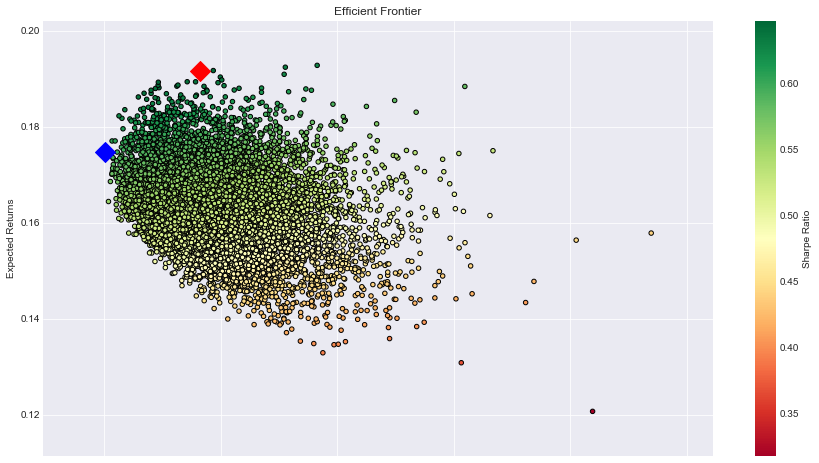

In [67]:
iterations = 10000

load_data = False

start = '2009-01-01'
end = '2019-03-01'
#list of stocks in portfolio
stock = ('600000.SS',
'600004.SS',
'600009.SS',
'600010.SS',
'600011.SS',
'600015.SS',
'600016.SS',
'600018.SS',
'600019.SS',
'600027.SS')

draw_efficient_frontier(stock, iterations, load_data)

In [101]:
rankpoint = rank_point(results_frame, 3)

0.0012199032811731625
0.2440140283411913


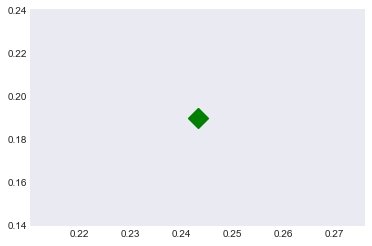

In [103]:
plt.scatter(x=rankpoint['Volatility'], y=rankpoint['Returns'], c='green', marker='D', s=200 )
plt.show()

In [ ]:
def next_year_return(data, weight):
    '''
    '''
    price = data.values@weight
    return price[-1]/price[0] - 1

def calculate_weight(data):
    #maximising sharpe ratio
    mu = mean_historical_return(data) #define mean as mu
    S = risk_models.sample_cov(data) #define covariance matrix as S
    ef = EfficientFrontier(mu, S) #build efficient frontier using ‘mu’ and ‘s’
    weight = ef.max_sharpe(risk_free_rate=0.03102) #risk free 10 year Chinese gov bond
    return weight

def slicing_data(data, start, end):
    temp_data = data[data.index >= start]
    temp_data = data[data.index <= end]
    return temp_data
    
def anualized_SR(data, weight):
    returns = data.pct_change()
    mean_daily_returns = returns.mean()
    cov_matrix = returns.cov()
    weight = np.array(weight)
    portfolio_return = np.sum(mean_daily_returns * weight) * 252 # need futhur considertation
    portfolio_std_dev = np.sqrt(np.dot(weight.T,np.dot(cov_matrix, weight))) * np.sqrt(252)
    return (portfolio_return - risk_free_rate)/portfolio_std_dev

In [ ]:
returns = []
sharpe_ratios = []
for yr in range(2009, 2019):
    print(yr)
    start = datetime.datetime(yr, 1, 1)
    end = datetime.datetime(yr + 1, 12, 31)
    price_data = slicing_data(df, start, end)
    weights = calculate_weight(price_data)
    print(weights)
    weights = [x for x in weights.values()] #jiahzushi 
    
    start = datetime.datetime(yr + 1, 1, 1)
    end = datetime.datetime(yr + 2, 12, 31)
    price_data = slicing_data(df, start, end)
    returns.append(next_year_return(price_data, weights))
    sharpe_ratios.append(anualized_SR(price_data, weights))
    
    
print("sharpe ratio :", (np.mean(returns) - risk_free_rate)/np.std(returns))
print("averate anualized sharpe ratio :", np.average(sharpe_ratios))

In [ ]:
returns = []

start = datetime.datetime(2009, 1, 1)
end = datetime.datetime(2015, 12, 31)
price_data = slicing_data(df, start, end)
weights = calculate_weight(price_data)
print(weights)
weights = [x for x in weights.values()]

start = datetime.datetime(2016, 1, 1)
end = datetime.datetime(2018, 12, 31)
price_data = slicing_data(df, start, end)
    
print("sharpe ratio :", anualized_SR(price_data, weights))